In [1]:
%load_ext autoreload

In [28]:
%autoreload

from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy import special, stats

key = jax.random.PRNGKey(0)

In [40]:
def mesh_eval(func, x_limits, y_limits, num_ticks):
    x = jnp.linspace(*x_limits, num_ticks)
    y = jnp.linspace(*y_limits, num_ticks)
    X, Y = jnp.meshgrid(x, y)
    xy_vec = jnp.stack([X.ravel(), Y.ravel()]).T
    zs = jax.vmap(func)(xy_vec)
    return X, Y, zs.reshape(*X.shape, -1)

In [298]:
@jax.jit
def log_density_mixture(x):
    params = (
        jnp.zeros(2),
        jnp.eye(2) / 4,
        jnp.ones(2) * 3,
        jnp.eye(2) / 5,
        0.7,
        0.3,
    )
    mean1, cov1, mean2, cov2, a, b = params
    return special.logsumexp(
        jnp.stack(
            (
                jnp.log(a) + stats.multivariate_normal.logpdf(x, mean=mean1, cov=cov1),
                jnp.log(b) + stats.multivariate_normal.logpdf(x, mean=mean2, cov=cov2),
            )
        ),
        axis=0,
    )

In [42]:
X, Y, Z = mesh_eval(score_mixture, (-2, 5), (-2, 5), 100)

In [45]:
Z.shape

(100, 100, 1)

CPU times: user 49.8 ms, sys: 6.11 ms, total: 55.9 ms
Wall time: 46.8 ms


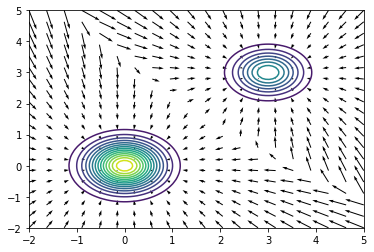

In [150]:
%%time
X, Y, Z = mesh_eval(
    score_mixture,
    (-2, 5),
    (-2, 5),
    20,
)
plt.quiver(X, Y, Z[:, :, 0], Z[:, :, 1])

X, Y, Z = mesh_eval(
    log_density_mixture,
    (-2, 5),
    (-2, 5),
    100,
)
plt.contour(X, Y, jnp.exp(Z[:, :, 0]), levels=15)

In [320]:
x = jnp.zeros(2)
M = fisher_mixture(x)
minv = jnp.linalg.inv(M)

In [322]:
M

DeviceArray([[ 4.0000000e+00, -3.4503604e-18],
             [-3.4503604e-18,  4.0000000e+00]], dtype=float32)

In [321]:
minv @

DeviceArray([[2.5000000e-01, 2.1564752e-19],
             [2.1564752e-19, 2.5000000e-01]], dtype=float32)

In [358]:
@partial(jax.jit, static_argnums=(0, 1, 2, 3))
def langevin_scan(score, fisher, dim, t, eps, scaling, x, key):
    zs = jax.random.normal(key, shape=(t, dim))

    def step_grad(x, z):
        diffusion = x + 0.5 * eps * eps * score(x) * scaling
        drift = eps * z
        x = diffusion + drift
        return x, x

    def step_ng(x, z):
        M = jnp.linalg.inv(fisher(x))
        L = jnp.linalg.cholesky(M)
        diffusion = x + 0.5 * eps * eps * minv @ score(x) * scaling
        drift = eps * L @ z
        x = diffusion + drift
        return x, x

    x, intermediate = jax.lax.scan(step_ng, x, zs)

    return x, intermediate


def langevin(log_likelihood, dim, t, eps, scaling, x, key):
    score = jax.jit(jax.grad(log_likelihood))
    fisher = jax.jit(lambda x: -jax.hessian(log_likelihood)(x))

    y, i = jax.vmap(
        langevin_scan, in_axes=(None, None, None, None, None, None, 0, None)
    )(score, fisher, dim, t, eps, scaling, x, key)
    i = i.transpose(1, 0, 2)
    return y, i

In [359]:
x = jax.random.uniform(key, shape=(1000, 2), minval=-2, maxval=5)

In [360]:
%%time
y, i = langevin(log_density_mixture, 2, 1000, 0.1, 1.0, x, key)

CPU times: user 2.98 s, sys: 31 ms, total: 3.01 s
Wall time: 1.62 s


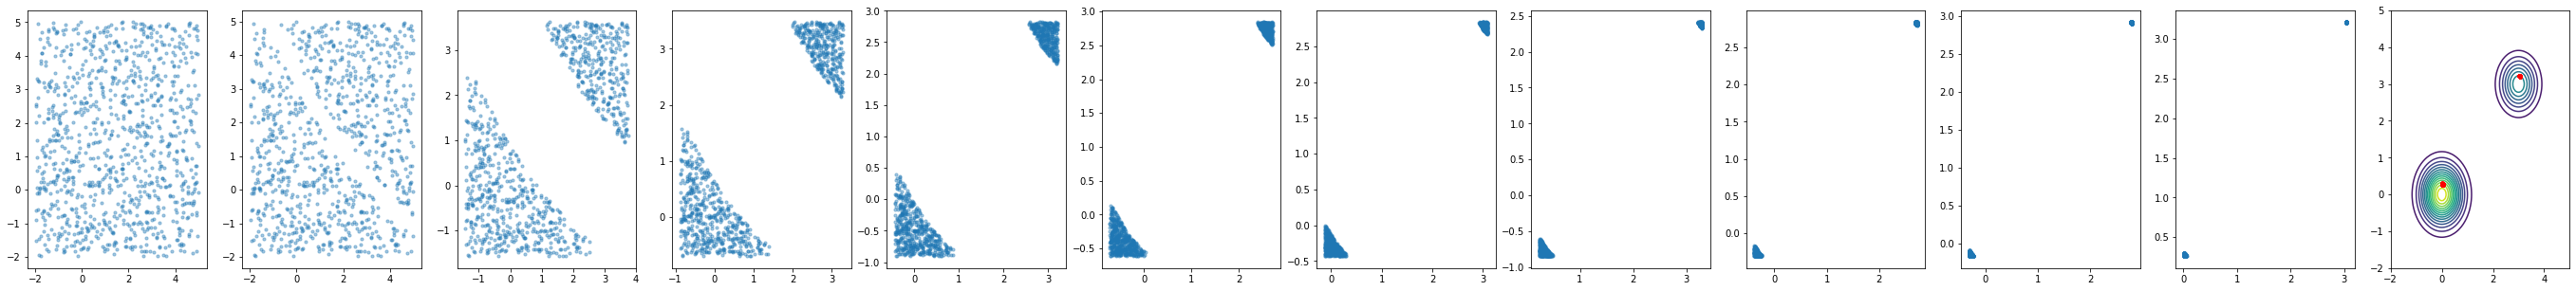

In [361]:
toplot = 10
every = (len(i) + 1) // (toplot - 1)
fig, ax = plt.subplots(1, toplot + 2, figsize=((toplot + 2) * 4, 5))
cfg = dict(alpha=0.4, s=10)
ax[0].scatter(x[:, 0], x[:, 1], **cfg)
for ix, j in enumerate(range(0, len(i), every)):
    if ix < toplot:
        # print(ix, j)
        ax[ix + 1].scatter(i[j][:, 0], i[j][:, 1], **cfg)
    else:
        break
ax[ix + 2].scatter(y[:, 0], y[:, 1], **cfg, zorder=5, c="r")
ax[ix + 2].contour(X, Y, jnp.exp(Z[:, :, 0]), levels=15)